In [30]:
import openpiv.tools
import openpiv.process
import openpiv.scaling
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [31]:
def computeVelocityField(image1, image2):
        thframe1 = cv2.adaptiveThreshold(image1.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
        thframe2 = cv2.adaptiveThreshold(image2.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
        u, v, sig2noise = openpiv.process.extended_search_area_piv( thframe1.astype(np.int32), \
                                                           thframe2.astype(np.int32), \
                                                           window_size=64, \
                                                           overlap=48, \
                                                           dt=1, \
                                                           search_area_size=128, \
                                                           sig2noise_method='peak2peak' )
        x, y = openpiv.process.get_coordinates( image_size=image1.shape, window_size=64, overlap=48 )
        u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.0 )
        u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
        x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 1 )
        #openpiv.tools.save(x, y, u, v, mask, )
        return (x,y,u,v)

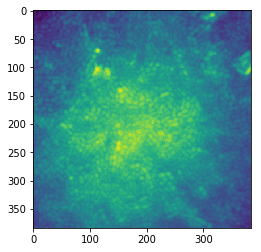

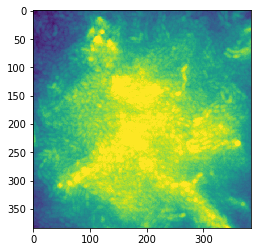

In [32]:
fpath = '/Users/timrudge/CavendishMicroscopy/10.01.16/Pos0000'
fnames = [fpath+'/Frame0/Frame0000Step%04d.tif', fpath+'/Frame0002Step%04d.tif']
nframes = 10
step = 5
nchannels = 2
frames = np.zeros((384,384,nchannels,nframes))
cvframes = np.zeros((384,384,nchannels,nframes))
for i in range(nframes):
    for j in range(nchannels):
        im = openpiv.tools.imread( fnames[j]%(i*step+163) ).astype(np.float32)
        frames[:,:,j,i]  = im[500:884,1100:1484]
        cvframes[:,:,j,i]  = 255.0*frames[:,:,j,i]/np.max(frames[:,:,j,i])
        cvframes[:,:,j,i] = cv2.GaussianBlur(cvframes[:,:,j,i],(5,5),0)
plt.imshow(frames[:,:,0,0])
plt.figure()
plt.imshow(frames[:,:,0,-1])

0
1
2
3
4
5
6
7
8


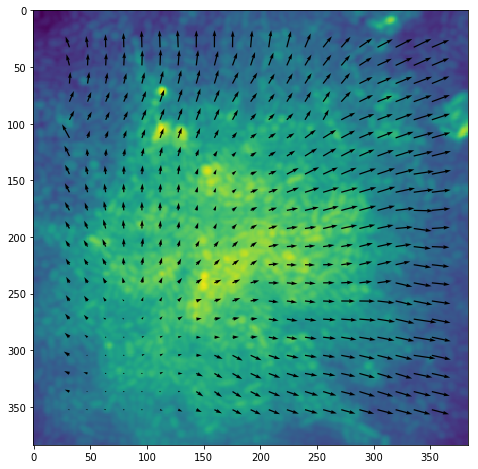

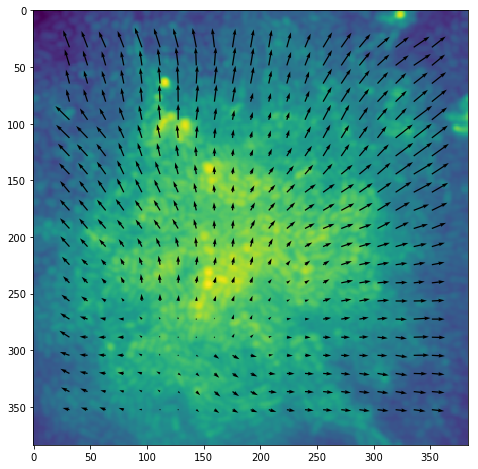

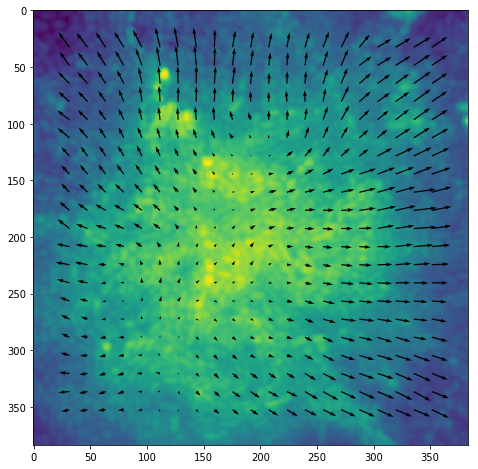

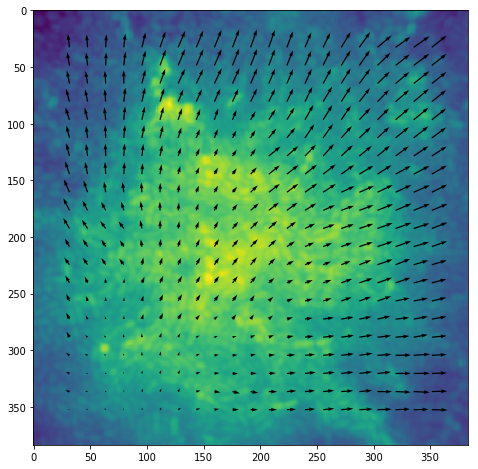

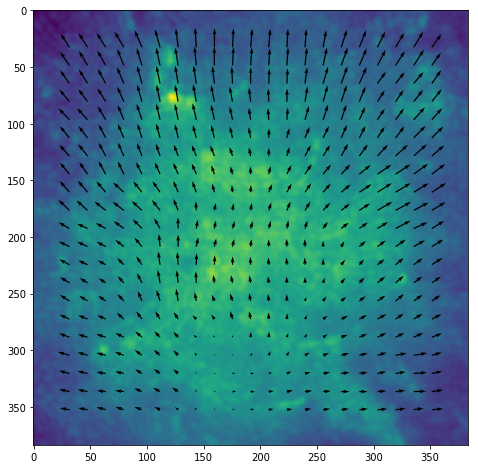

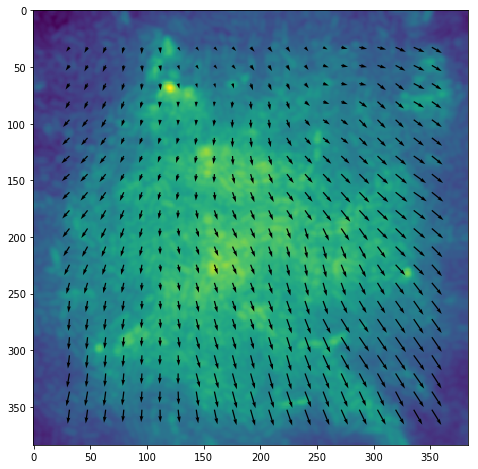

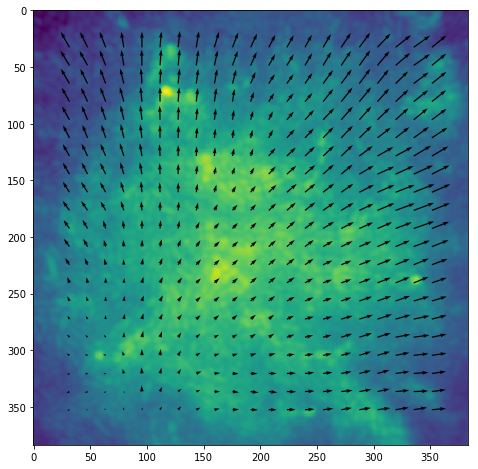

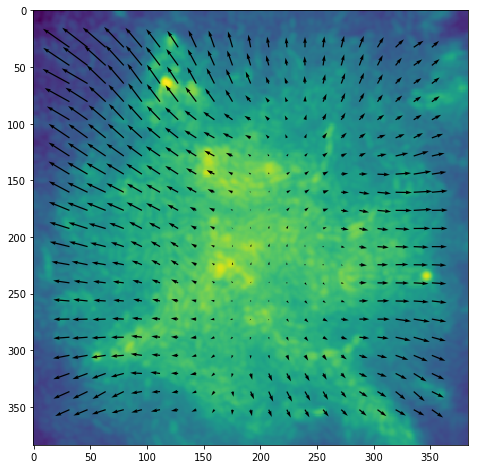

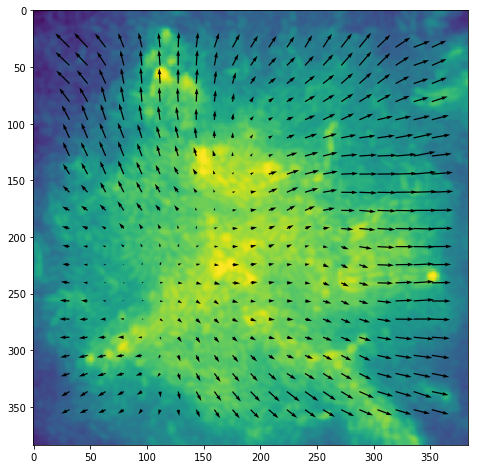

In [33]:
vel = np.zeros((21,21,2,nframes-1))
svel = np.zeros((21,21,2,nframes-1))
div = np.zeros((20,20,nframes-1))
for i in range(nframes-1):
    print i
    im1 = cvframes[:,:,0,i]
    im2 = cvframes[:,:,0,i+1]
    (x,y,u,v) = computeVelocityField(im1,im2)
    vel[:,:,0,i] = u
    vel[:,:,1,i] = v
    svel[:,:,0,i] = cv2.GaussianBlur(u,(15,15),0)
    svel[:,:,1,i] = cv2.GaussianBlur(v,(15,15),0)
    du = np.diff(svel[:,:,0,i], axis=0)
    dv = np.diff(svel[:,:,1,i], axis=1)
    div[:,:,i] = du[:,:-1] + dv[:-1,:]
    
    plt.figure(figsize=(8,8))
    plt.imshow(im1)
    plt.quiver( x, im1.shape[0]-y, u, v )

    

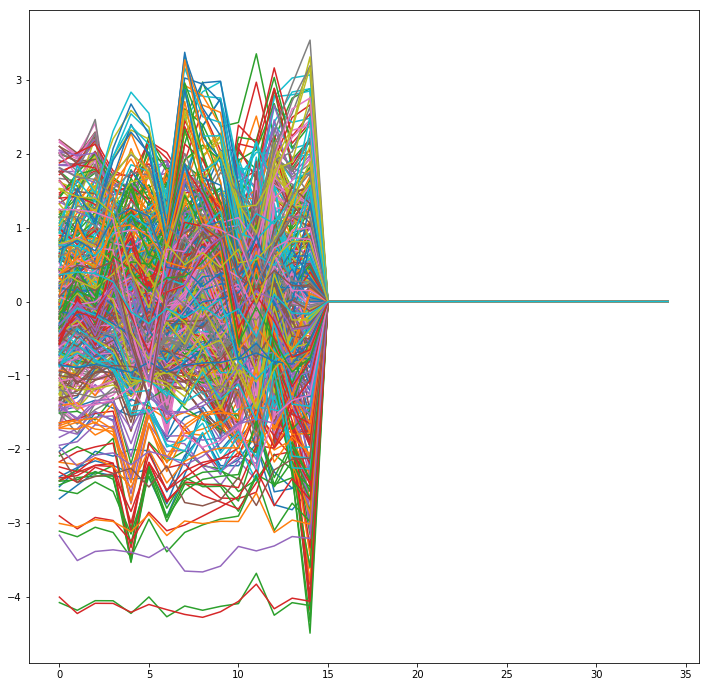

In [102]:
plt.figure(figsize=(12,12))
for i in range(20):
    for j in range(20):
        plt.plot(div[i,j,:])